# Forecasting Building Energy Use

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import os

mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False

import pandas as pd
import numpy as np
from datetime import datetime

from fbprophet import Prophet

In [2]:
df = pd.read_csv('forecast_data_v1.csv')

In [3]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [4]:
df

Datetime  ...  Outside Air Temp (C)
0    2020-06-01 01:00:00  ...                  14.6
1    2020-06-01 02:00:00  ...                  13.6
2    2020-06-01 03:00:00  ...                  13.6
3    2020-06-01 04:00:00  ...                  12.6
4    2020-06-01 05:00:00  ...                  12.6
...                  ...  ...                   ...
8754 2021-05-31 19:00:00  ...                  23.0
8755 2021-05-31 20:00:00  ...                  24.0
8756 2021-05-31 21:00:00  ...                  22.0
8757 2021-05-31 22:00:00  ...                  21.0
8758 2021-05-31 23:00:00  ...                  21.0

[8759 rows x 4 columns]

Building Energy Consumption Line Plot

In [5]:
fig = px.line(df, x='Datetime', y='Hourly Energy Cons (kWh)', hover_data=['Outside Air Temp (C)'], title='Building Energy Consumption')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=2, label="3m", step="month", stepmode="backward"),
            dict(count=3, label="6m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

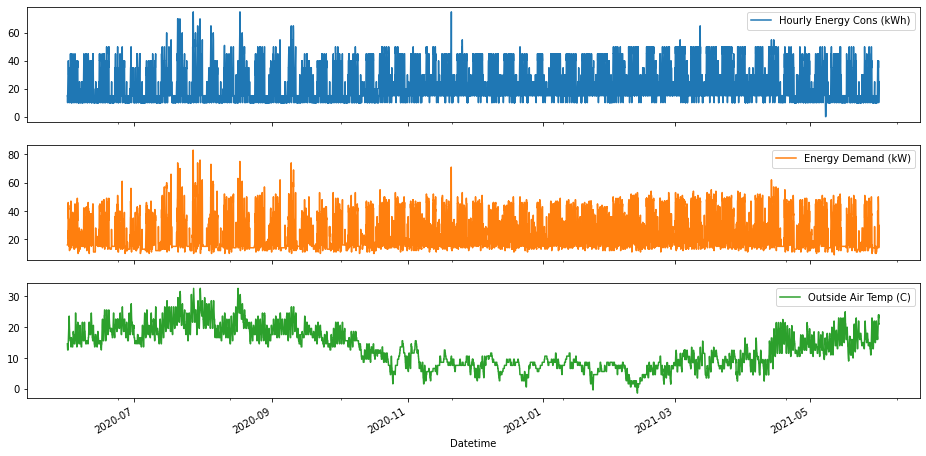

In [6]:
plot_df = df.set_index('Datetime')

plot_df.plot(figsize=(16,8),subplots=True);

## Univariate Forecast of Energy Consumption  
### Baseline Forecast Model

In [7]:
df_uni = df.reset_index()[['Datetime', 'Hourly Energy Cons (kWh)']].copy()
df_uni.columns = ['ds', 'y']

In [8]:
df_uni

ds     y
0    2020-06-01 01:00:00  15.0
1    2020-06-01 02:00:00  15.0
2    2020-06-01 03:00:00  10.0
3    2020-06-01 04:00:00  15.0
4    2020-06-01 05:00:00  15.0
...                  ...   ...
8754 2021-05-31 19:00:00  10.0
8755 2021-05-31 20:00:00  15.0
8756 2021-05-31 21:00:00  15.0
8757 2021-05-31 22:00:00  25.0
8758 2021-05-31 23:00:00  25.0

[8759 rows x 2 columns]

In [9]:
df_uni.isnull().sum()

ds    0
y     0
dtype: int64

In [10]:
# first try to predict on a 1 week time period: 168 hours
# train test split
test_uni = df_uni[(df_uni['ds'] >= '2021-05-25 00:00:00')]     # last week of data
train_uni = df_uni[(df_uni['ds'] < '2021-05-25 00:00:00')]

In [11]:
print(train_uni.shape)
print(test_uni.shape)

(8591, 2)
(168, 2)


In [12]:
train_uni.tail()

ds     y
8586 2021-05-24 19:00:00  15.0
8587 2021-05-24 20:00:00  10.0
8588 2021-05-24 21:00:00  15.0
8589 2021-05-24 22:00:00  10.0
8590 2021-05-24 23:00:00  15.0

In [13]:
test_uni

ds     y
8591 2021-05-25 00:00:00  15.0
8592 2021-05-25 01:00:00  15.0
8593 2021-05-25 02:00:00  10.0
8594 2021-05-25 03:00:00  15.0
8595 2021-05-25 04:00:00  15.0
...                  ...   ...
8754 2021-05-31 19:00:00  10.0
8755 2021-05-31 20:00:00  15.0
8756 2021-05-31 21:00:00  15.0
8757 2021-05-31 22:00:00  25.0
8758 2021-05-31 23:00:00  25.0

[168 rows x 2 columns]

In [14]:
# prophet
m = Prophet(interval_width=0.9) # 90% CI
m.fit(train_uni)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [15]:
future = m.make_future_dataframe(periods=len(test_uni), freq='H')
future

ds
0    2020-06-01 01:00:00
1    2020-06-01 02:00:00
2    2020-06-01 03:00:00
3    2020-06-01 04:00:00
4    2020-06-01 05:00:00
...                  ...
8753 2021-05-31 19:00:00
8754 2021-05-31 20:00:00
8755 2021-05-31 21:00:00
8756 2021-05-31 22:00:00
8757 2021-05-31 23:00:00

[8758 rows x 1 columns]

In [16]:
forecast = m.predict(future)

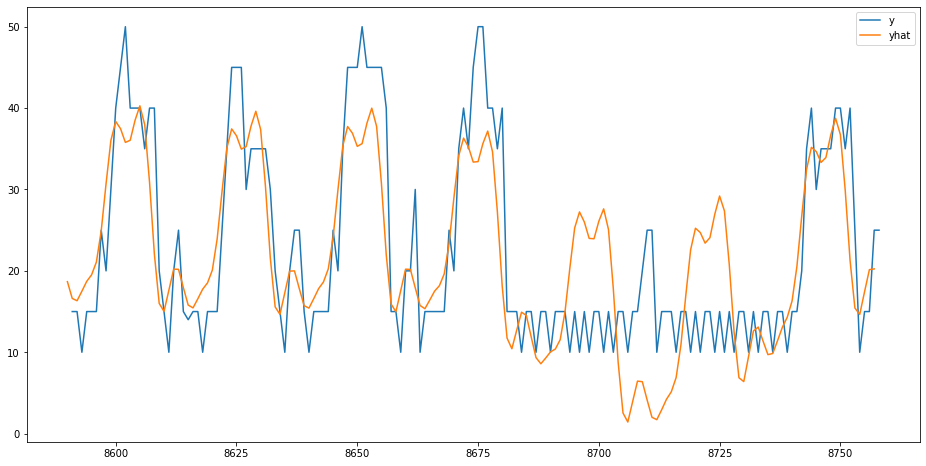

In [17]:
pd.concat([test_uni['y'], forecast['yhat'][-168:]], axis=1).plot(figsize=(16,8));

In [18]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [19]:
plot_components_plotly(m, forecast)

In [80]:
# model evaluation
from fbprophet.diagnostics import cross_validation, performance_metrics

cv_results = cross_validation(m, initial='3000 hours', horizon='720 hours')
cv_results.head()

INFO:fbprophet:Making 14 forecasts with cutoffs between 2020-10-11 23:00:00 and 2021-04-24 23:00:00


ds       yhat  ...     y              cutoff
0 2020-10-12 00:00:00  13.322522  ...  15.0 2020-10-11 23:00:00
1 2020-10-12 01:00:00  12.307620  ...  15.0 2020-10-11 23:00:00
2 2020-10-12 02:00:00  13.041414  ...  15.0 2020-10-11 23:00:00
3 2020-10-12 03:00:00  14.740896  ...  15.0 2020-10-11 23:00:00
4 2020-10-12 04:00:00  15.665828  ...  20.0 2020-10-11 23:00:00

[5 rows x 6 columns]

In [81]:
df_uni_performance = performance_metrics(cv_results)
df_uni_performance

INFO:fbprophet:Skipping MAPE because y close to 0


horizon        mse      rmse       mae     mdape  coverage
0    3 days 00:00:00  48.607642  6.971918  5.717300  0.191904  0.956349
1    3 days 01:00:00  48.720705  6.980022  5.728881  0.193595  0.955357
2    3 days 02:00:00  48.699492  6.978502  5.734382  0.194000  0.955357
3    3 days 03:00:00  49.172404  7.012304  5.751765  0.194173  0.954365
4    3 days 04:00:00  49.434646  7.030978  5.770616  0.195159  0.953373
..               ...        ...       ...       ...       ...       ...
644 29 days 20:00:00  69.742053  8.351171  6.835021  0.226155  0.878968
645 29 days 21:00:00  69.545663  8.339404  6.830223  0.227166  0.879960
646 29 days 22:00:00  69.506442  8.337052  6.835396  0.228626  0.879960
647 29 days 23:00:00  70.377536  8.389132  6.873358  0.227894  0.876984
648 30 days 00:00:00  70.238372  8.380834  6.867106  0.227166  0.878968

[649 rows x 6 columns]

## Multivariate Forecast of Energy Consumption  
### Better Forecast Model

In [22]:
df_multi = df.copy()
df_multi.columns = ['ds', 'y', 'demand', 'temp']
df_multi

ds     y  demand  temp
0    2020-06-01 01:00:00  15.0    16.0  14.6
1    2020-06-01 02:00:00  15.0    16.0  13.6
2    2020-06-01 03:00:00  10.0    16.0  13.6
3    2020-06-01 04:00:00  15.0    16.0  12.6
4    2020-06-01 05:00:00  15.0    16.0  12.6
...                  ...   ...     ...   ...
8754 2021-05-31 19:00:00  10.0    14.0  23.0
8755 2021-05-31 20:00:00  15.0    14.0  24.0
8756 2021-05-31 21:00:00  15.0    27.0  22.0
8757 2021-05-31 22:00:00  25.0    30.0  21.0
8758 2021-05-31 23:00:00  25.0    22.0  21.0

[8759 rows x 4 columns]

In [23]:
df_multi.describe()

y       demand         temp
count  8759.000000  8759.000000  8759.000000
mean     24.682612    25.405982    13.061080
std      12.692877    12.779742     6.247983
min       0.000000     9.000000    -1.400000
25%      15.000000    15.000000     7.600000
50%      20.000000    20.000000    12.500000
75%      35.000000    35.000000    17.600000
max      75.000000    83.000000    32.600000

In [24]:
# demand is extremely correlated with consumption, basically providing the model with the info it needs to predict exactly
# if this data is available before consuption it might be usable, if not it is leakage
df_multi[['y','demand']].corr()

y    demand
y       1.000000  0.943974
demand  0.943974  1.000000

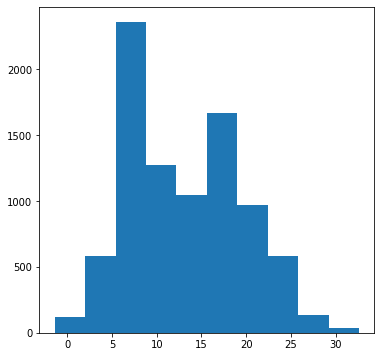

In [37]:
plt.figure(figsize=(6,6))
plt.hist(df_multi['temp']);

In [25]:
df_multi[['y','temp']].corr()

y     temp
y     1.00000 -0.05946
temp -0.05946  1.00000

In [83]:
df_multi.query('temp > 18')[['y','temp']].corr()

y      temp
y     1.000000  0.227559
temp  0.227559  1.000000

In [32]:
df_multi.query('temp <= 18')[['y','temp']].corr()

y      temp
y     1.000000 -0.143997
temp -0.143997  1.000000

In [42]:
def temp_thresh(temp):
  if temp > 18:
    return 1
  return 0

In [43]:
df_multi['temp thresh'] = df_multi['temp'].apply(temp_thresh)

In [44]:
df_multi['month'] = df_multi['ds'].dt.month

In [45]:
# check temperature distribution by month to confirm
df_multi[['temp', 'month']].groupby('month').agg({'temp':{'min', 'max', 'mean'}})

temp            
            mean   min   max
month                       
1       7.551613  -0.4  11.6
2       5.332738  -1.4  10.6
3       8.809421   2.5  15.5
4      12.683333   2.5  22.5
5      15.778226   9.0  25.0
6      18.373296  12.6  27.6
7      21.149731  13.6  32.6
8      20.574462  13.6  32.6
9      18.415278  12.6  26.6
10     12.171237   1.6  21.6
11      8.199168   1.6  15.6
12      7.129570   0.6  11.6

In [46]:
# train test split
#df_multi = df_multi.drop(['demand'], axis=1)
test_multi = df_multi[(df_multi['ds'] >= '2021-05-25 00:00:00')]     # last week of data
train_multi = df_multi[(df_multi['ds'] < '2021-05-25 00:00:00')]

In [84]:
print(train_multi.shape)
print(test_multi.shape)

(8591, 6)
(168, 6)


In [85]:
test_multi.tail()

ds     y  demand  temp  temp thresh  month
8754 2021-05-31 19:00:00  10.0    14.0  23.0            1      5
8755 2021-05-31 20:00:00  15.0    14.0  24.0            1      5
8756 2021-05-31 21:00:00  15.0    27.0  22.0            1      5
8757 2021-05-31 22:00:00  25.0    30.0  21.0            1      5
8758 2021-05-31 23:00:00  25.0    22.0  21.0            1      5

In [86]:
m_multi = Prophet(interval_width=0.9)
m_multi.add_regressor('demand')
m_multi.add_regressor('temp thresh', standardize=False)
#m_multi.add_regressor('month')

In [87]:
m_multi.fit(train_multi)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [88]:
future_multi = m_multi.make_future_dataframe(periods=len(test_multi), freq='H')
future_multi.tail()

ds
8753 2021-05-31 19:00:00
8754 2021-05-31 20:00:00
8755 2021-05-31 21:00:00
8756 2021-05-31 22:00:00
8757 2021-05-31 23:00:00

In [89]:
future_multi['demand'] = df_multi['demand']
future_multi['temp thresh'] = df_multi['temp thresh']
#future_multi['month'] = df_multi['month']

In [90]:
future_multi

ds  demand  temp thresh
0    2020-06-01 01:00:00    16.0            0
1    2020-06-01 02:00:00    16.0            0
2    2020-06-01 03:00:00    16.0            0
3    2020-06-01 04:00:00    16.0            0
4    2020-06-01 05:00:00    16.0            0
...                  ...     ...          ...
8753 2021-05-31 19:00:00    14.0            1
8754 2021-05-31 20:00:00    14.0            1
8755 2021-05-31 21:00:00    14.0            1
8756 2021-05-31 22:00:00    27.0            1
8757 2021-05-31 23:00:00    30.0            1

[8758 rows x 3 columns]

In [91]:
forecast_multi = m_multi.predict(future_multi)

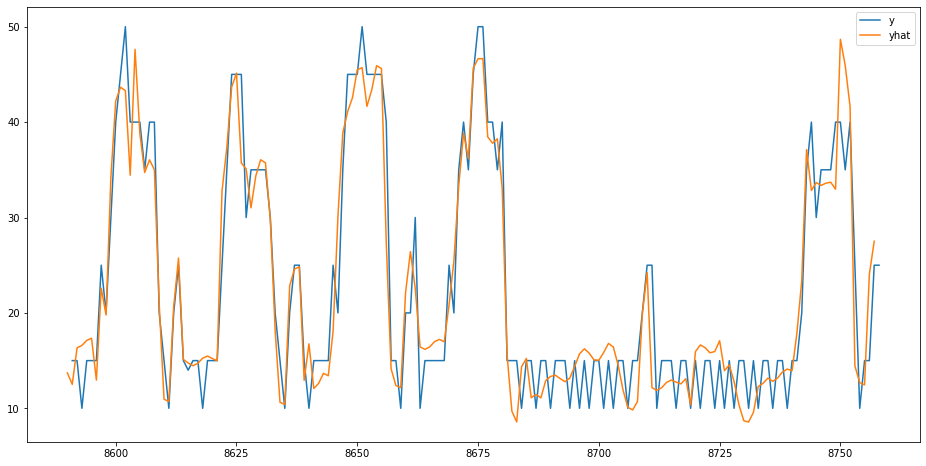

In [92]:
pd.concat([test_multi['y'], forecast_multi['yhat'][-168:]], axis=1).plot(figsize=(16,8));

In [93]:
plot_plotly(m_multi, forecast_multi)

In [94]:
plot_components_plotly(m_multi, forecast_multi)

In [96]:
cv_results_multi = cross_validation(m_multi, initial='3000 hours', horizon='720 hours')
cv_results_multi.head()

INFO:fbprophet:Making 14 forecasts with cutoffs between 2020-10-11 23:00:00 and 2021-04-24 23:00:00


ds       yhat  ...     y              cutoff
0 2020-10-12 00:00:00  15.219195  ...  15.0 2020-10-11 23:00:00
1 2020-10-12 01:00:00  15.185872  ...  15.0 2020-10-11 23:00:00
2 2020-10-12 02:00:00  15.243199  ...  15.0 2020-10-11 23:00:00
3 2020-10-12 03:00:00  15.626038  ...  15.0 2020-10-11 23:00:00
4 2020-10-12 04:00:00  16.863235  ...  20.0 2020-10-11 23:00:00

[5 rows x 6 columns]

In [97]:
df_multi_performance = performance_metrics(cv_results_multi)
df_multi_performance

INFO:fbprophet:Skipping MAPE because y close to 0


horizon        mse      rmse       mae     mdape  coverage
0    3 days 00:00:00  14.804663  3.847683  2.922660  0.096420  0.913690
1    3 days 01:00:00  15.071209  3.882166  2.931953  0.095775  0.912698
2    3 days 02:00:00  15.152739  3.892652  2.937034  0.095392  0.911706
3    3 days 03:00:00  15.089648  3.884540  2.928394  0.094644  0.913478
4    3 days 04:00:00  14.986437  3.871232  2.913928  0.094213  0.915533
..               ...        ...       ...       ...       ...       ...
644 29 days 20:00:00  15.815528  3.976874  2.989523  0.093101  0.898810
645 29 days 21:00:00  15.793598  3.974116  2.987216  0.093101  0.897817
646 29 days 22:00:00  15.548181  3.943118  2.964439  0.093411  0.900794
647 29 days 23:00:00  15.710438  3.963639  2.978754  0.093101  0.897817
648 30 days 00:00:00  15.673248  3.958945  2.973021  0.092390  0.898810

[649 rows x 6 columns]